# Table of Contents
 <p>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{Cov}
    \DeclareMathOperator{\var}{Var}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \DeclareMathOperator*{\gp}{\mathcal{GP}}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\scrS}{\mathscr{S}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
    \newcommand{\sigmatau}{\sigma_{\tau}}
    \newcommand{\sigmabeta}{\sigma_{\beta}}
    \newcommand{\sigmamu}{\sigma_{\mu}}
    \newcommand{\sigmagamma}{\sigma_{\gamma}}
    \newcommand{\svec}{\mathbf{s}}
    \newcommand{\yvec}{\mathbf{y}}
    \newcommand{\muvec}{\mathbf{\mu}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\vectreat}{\Ind_{T}}
    \newcommand{\yt}{Y^\mathrm{T}}
    \newcommand{\yc}{Y^\mathrm{C}}
    \newcommand{\boundary}{\partial}
    \newcommand{\sentinels}{\mathbf{\boundary}}
    \newcommand{\eye}{\mathbf{I}}
    \newcommand{\K}{\mathbf{K}}
    \DeclareMathOperator{\trace}{trace}
    \newcommand{\linavg}{\bar{\tau}}
    \newcommand{\invvar}{\tau^{IV}}
    \newcommand{\modnull}{\mathscr{M}_0}
    \newcommand{\modalt}{\mathscr{M}_1}
    \newcommand{\degree}{\hspace{0pt}^\circ}
$$

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
X_LA = readcsv("Mississippi_data/X_LA.csv")
X_MS = readcsv("Mississippi_data/X_MS.csv")
LA_dist = readcsv("Mississippi_data/LA_Dist.csv")
MS_dist = readcsv("Mississippi_data/MS_Dist.csv")
sentinels = readcsv("Mississippi_data/sentinels.csv")
;

In [3]:
Y_MS = zeros(length(MS_dist))
Y_LA = zeros(length(LA_dist))
;

In [4]:
include("src/GeoRDD.jl")

GeoRDD

In [5]:
k = SEIso(log(5e4), 0.0)
k2 = k + GeoRDD.ConstantKernel(log(10.0))

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [10.8198,0.0]
  Type: GeoRDD.ConstantKernel, Params: [2.30259]


In [6]:
@time p_invvar_calib_sims = GeoRDD.nsim_invvar_calib(gp_MS, gp_LA, sentinels, 100; update_mean=false);

LoadError: UndefVarError: gp_MS not defined

In [7]:
gp_MS = GP(X_MS, Y_MS, MeanZero(), k2, 0.0)
gp_LA = GP(X_LA, Y_LA, MeanZero(), k2, 0.0)
;

In [8]:
cliff = GeoRDD.cliff_face(gp_MS, gp_LA, sentinels);

In [9]:
GeoRDD.inverse_variance(cliff[1], cliff[2])

Distributions.Normal{Float64}(μ=0.0, σ=0.3632372461956376)

In [10]:
@time p_invvar_sims = GeoRDD.nsim_invvar_pval(gp_MS, gp_LA, sentinels, 10000; update_mean=false);

237.357869 seconds (2.64 G allocations: 161.395 GB, 8.61% gc time)


In [11]:
@time mLL_sims = GeoRDD.nsim_logP(gp_MS, gp_LA, 10000; update_mean=false);

mLL_sim_null = [sim[1] for sim in mLL_sims]
mLL_sim_altv = [sim[2] for sim in mLL_sims]
;

  1.722811 seconds (813.43 k allocations: 176.859 MB, 1.23% gc time)


In [12]:
@time chi_sims_μ = GeoRDD.nsim_chi(gp_MS, gp_LA, sentinels, 10000; update_mean=false);

215.302003 seconds (2.63 G allocations: 131.453 GB, 14.89% gc time)


In [13]:
τ=0.5
@time power_sims = GeoRDD.nsim_power(gp_MS, gp_LA, τ, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000;
                  update_mean=false
                  );

1063.535192 seconds (11.01 G allocations: 590.351 GB, 23.71% gc time)


In [14]:
@time power_sims_null = GeoRDD.nsim_power(gp_MS, gp_LA, 0.0, sentinels, 
                  chi_sims_μ, mLL_sim_altv.-mLL_sim_null, p_invvar_sims,
                  10000;
                  update_mean=false
                  );

1067.501076 seconds (11.01 G allocations: 590.330 GB, 23.56% gc time)


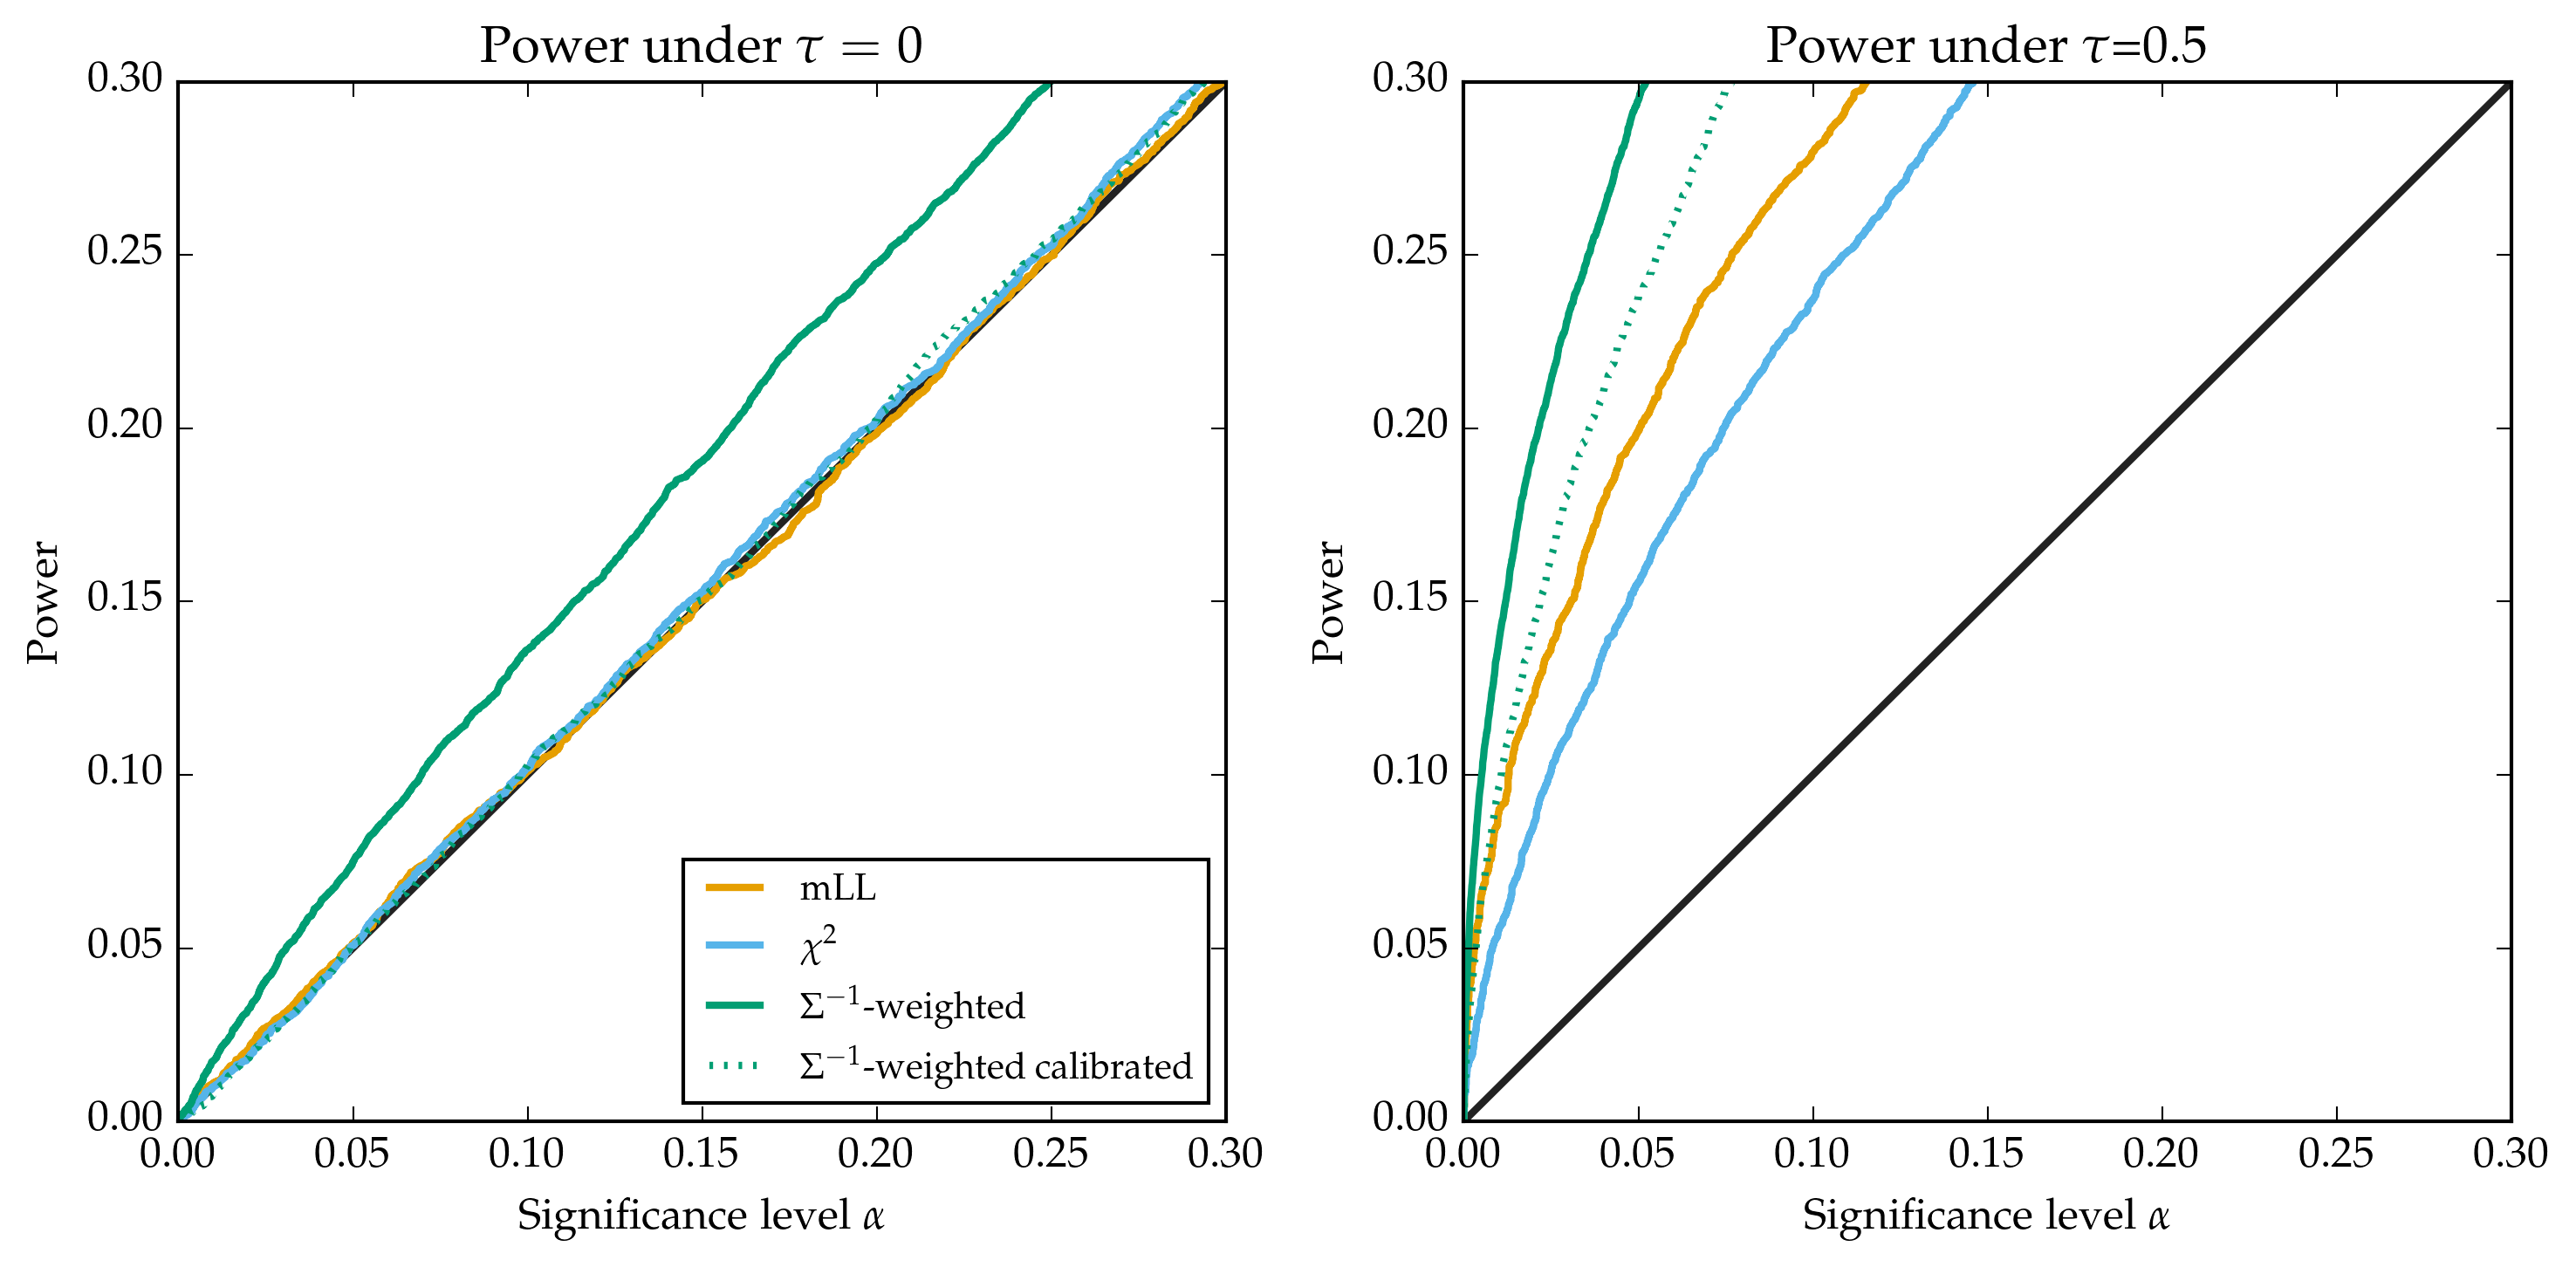

In [26]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
bins=linspace(0,1.1,1000)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims_null]), 
#          linspace(0,1,length(power_sims_null)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims_null]), 
         linspace(0,1,length(power_sims_null)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
plt.legend(loc="lower right", fontsize="small")
plt.title(L"Power under $\tau=0$")
plt.xlim(0,0.3)
plt.ylim(0,0.3)

plt.subplot(1,2,2)
plt.plot([0.0,1.0],[0.0,1.0], color="#222222", linewidth=2)
plt.plot(sort([s[1] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[1],
         label="mLL",
         linewidth=2,
        )
plt.plot(sort([s[2] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[2],
         label=L"\chi^2",
         linewidth=2,
        )
plt.plot(sort([s[3] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[3],
         label=L"$\Sigma^{-1}$-weighted",
         linewidth=2,
        )
# bootstrap calibration
# plt.plot(sort([s[5] for s in power_sims]), 
#          linspace(0,1,length(power_sims)),
#          color=cbbPalette[3],
#          linestyle=":",  
#          label=L"$\Sigma^{-1}$-weighted calibrated",
#          linewidth=2,
# )
plt.plot(sort([s[5] for s in power_sims]), 
         linspace(0,1,length(power_sims)),
         color=cbbPalette[3],
         linestyle=":",  
         label=L"$\Sigma^{-1}$-weighted calibrated",
         linewidth=2,
)
plt.xlabel(L"Significance level $\alpha$")
plt.ylabel("Power")
# plt.legend(loc="lower right", fontsize="small")
plt.title(@sprintf("Power under \$\\tau\$=%.1f", τ))
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.savefig("figures/power_HT.png")
plt.savefig("figures/power_HT.pdf")
;